In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/MyDrive/news-recommendation/data/' # 天池平台路径
save_path = '/content/drive/MyDrive/news-recommendation/temp_results/'  # 天池平台路径

1. 每个文件有哪些数据
2. 文件中每个字段的含义
3. 特征之间的相关性
推荐场景下，主要就是分析用户本身的基本属性，文章基本属性，用户和文章交互的一些分布

当**特征工程**和**模型调参**已经很难继续上分了，可以重新从新的角度去分析这些数据

# 发现
1. 训练集和测试集的用户id没有重复，也就是测试集里面的用户模型是没有见过的
2. 训练集中用户最少的点击文章数是2， 而测试集里面用户最少的点击文章数是1
3. 用户对于文章存在重复点击的情况， 但这个都存在于训练集里面
4. 同一用户的点击环境存在不唯一的情况，后面做这部分特征的时候可以采用统计特征
5. 用户点击文章的次数有很大的区分度，后面可以根据这个制作衡量用户活跃度的特征
6. 文章被用户点击的次数也有很大的区分度，后面可以根据这个制作衡量文章热度的特征
7. 用户看的新闻，相关性是比较强的，所以往往我们判断用户是否对某篇文章感兴趣的时候， 在很大程度上会和他历史点击过的文章有关
8. 用户点击的文章字数有比较大的区别， 这个可以反映用户对于文章字数的区别
9. 用户点击过的文章主题也有很大的区别， 这个可以反映用户的主题偏好 10.不同用户点击文章的时间差也会有所区别， 这个可以反映用户对于文章时效性的偏好

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.set_loglevel('error')
import seaborn as sns

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [4]:
#####train
trn_click = pd.read_csv(data_path+'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(data_path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(data_path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(data_path+'testA_click_log.csv')

# 数据预处理
计算用户点击rank和点击次数

In [5]:
# 对每个用户的点击时间戳进行排序，添加 rank 列
trn_click = trn_click.sort_values(['user_id','click_timestamp'], ascending=[True, False])
trn_click['rank'] = trn_click.groupby('user_id').cumcount() + 1

tst_click = tst_click.sort_values(['user_id','click_timestamp'], ascending=[True, False])
tst_click['rank'] = tst_click.groupby('user_id').cumcount() + 1

'''
解决并列时间导致的名次不唯一问题
'''

'\n解决并列时间导致的名次不唯一问题\n'

In [6]:
# 对用户，统计点击次数
# groupby('user_id')：按用户分组
# ['click_timestamp'].transform('count')：对每个用户组，统计该列的非空行数（即点击事件条数），用 transform 广播到组内每一行
# click_cnts 表示“该用户在当前 DataFrame（训练/测试各自）里的点击总次数

trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [7]:
# 用户点击日志
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,0,157507,1508211702520,4,1,17,1,25,2,1,2,281,1508236945000,370
1,0,30760,1508211672520,4,1,17,1,25,2,2,2,26,1508185091000,162
2,1,63746,1508211346889,4,1,17,1,25,6,1,2,133,1508142585000,162
3,1,289197,1508211316889,4,1,17,1,25,6,2,2,418,1508179909000,176
4,2,168401,1508211468695,4,3,20,1,25,2,1,2,297,1507663321000,215


In [8]:
# 用户点击日志信息：数据量，是否有空值，数据类型
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 118.8 MB


In [9]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118521e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016096e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [10]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [11]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

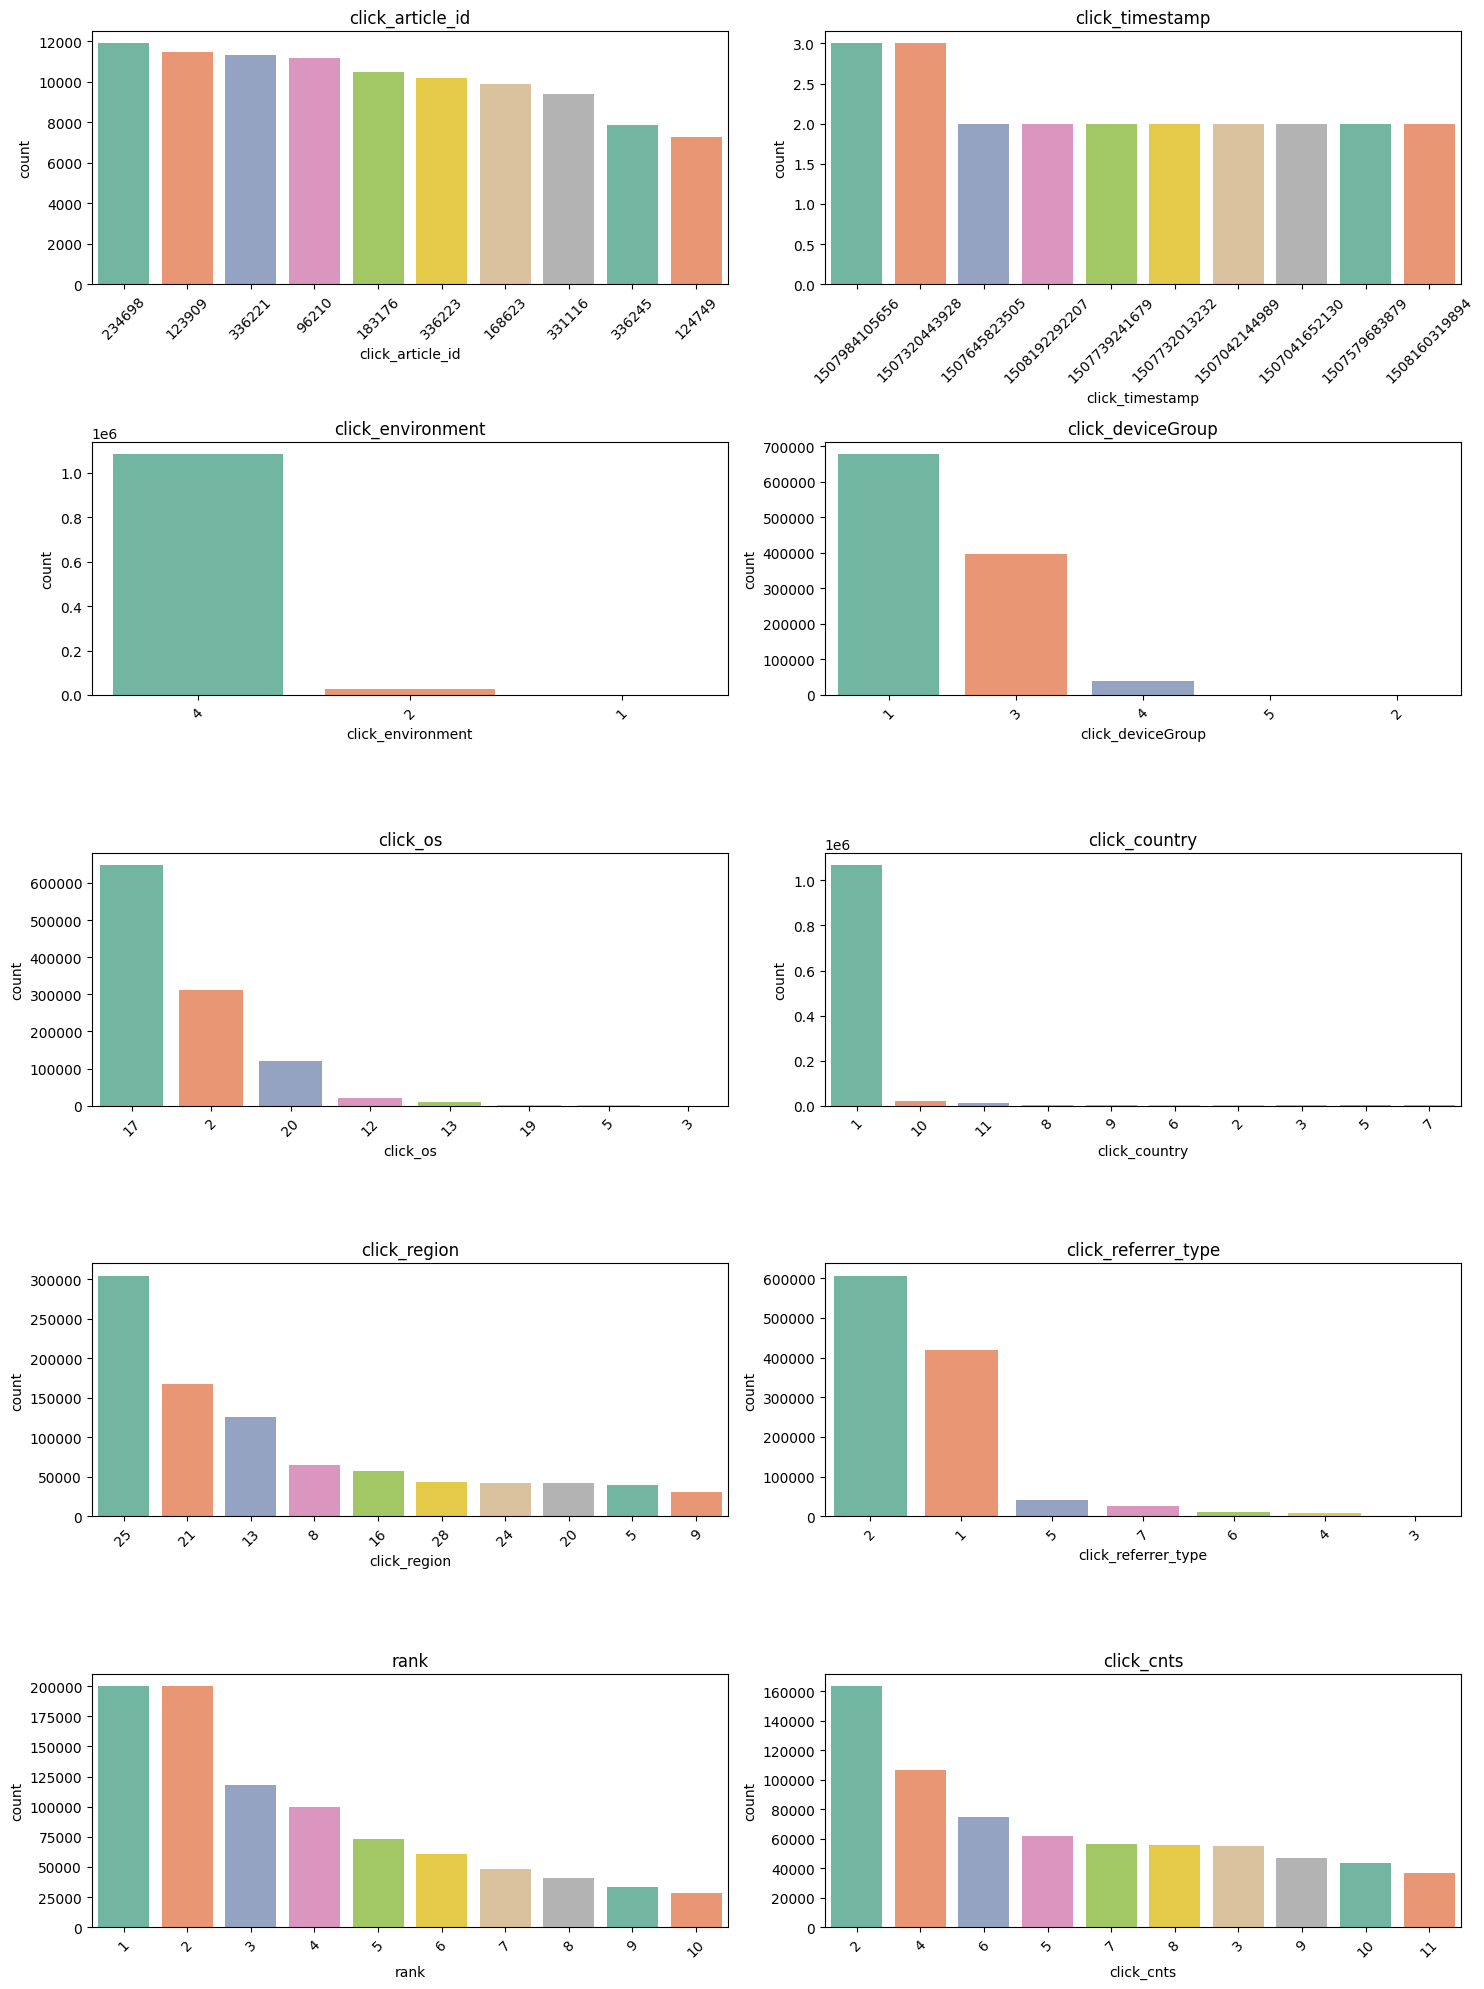

In [12]:
# 直方图：基本的属性分布

cols = ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup',
        'click_os', 'click_country', 'click_region', 'click_referrer_type', 'rank', 'click_cnts']

plt.figure(figsize=(15, 20))
for i, col in enumerate(cols, start=1):
    ax = plt.subplot(5, 2, i)
    v = (trn_click[col]
         .value_counts(dropna=False)
         .head(10)
         .reset_index(name='cnt')
         .rename(columns={'index': col}))
    v[col] = v[col].astype(str)

    sns.barplot(data=v, x=col, y='cnt', ax=ax, palette='Set2')  # 横向：计数在 x，类别在 y
    ax.set_title(f'{col}')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('count')

plt.tight_layout()
plt.show()


- 从点击环境click_environment来看，仅有2102次（占0.19%）点击环境为1；仅有25894次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。
- 从点击设备组click_deviceGroup来看，设备1占大部分（61%），设备3占36%。

# 测试集用户

In [13]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,200000,194300,1507651461280,4,1,17,1,17,1,1,3,317,1507636150000,202
1,200000,191971,1507030393999,4,1,17,1,17,1,2,3,309,1507013094000,222
2,200000,195839,1507030363999,4,1,17,1,17,1,3,3,317,1507011388000,177
3,200001,175040,1507029536442,4,3,2,1,18,7,1,1,299,1506974928000,176
4,200002,207714,1507292884188,4,1,17,1,8,1,1,7,331,1507222410000,256


In [14]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521793,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


可以看出，测试集用户和训练集用户没有重合

In [15]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()

50000

In [16]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

In [17]:
tst_click['click_cnts'].value_counts().sort_index()

,count
click_cnts,
1,9520
2,4612
3,16167
4,11224
5,17660
...,...
259,259
326,326
361,361


# 新闻文章信息数据表

In [18]:
#新闻文章数据集浏览
pd.concat([item_df.head(), item_df.tail()])

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [19]:
item_df['words_count'].value_counts()

,count
words_count,
176,3485
182,3480
179,3463
178,3458
174,3456
...,...
556,1
625,1
2798,1


461


<Axes: >

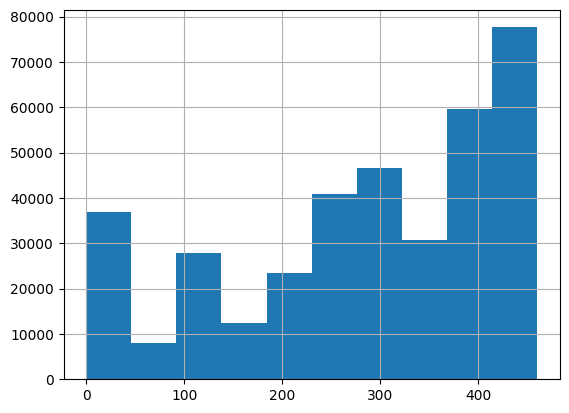

In [20]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

In [21]:
item_df.shape

(364047, 4)

# 新闻文章embedding向量表示

In [22]:
print(item_emb_df.shape)
item_emb_df.head()

(255756, 251)


,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


# 数据分析
使用合并数据（train + test）进行数据分析

In [23]:
user_click_merge = pd.concat([trn_click, tst_click])

## 用户重复点击

In [24]:
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
'''
groupby(['user_id', 'click_article_id'])

Original
user_id | article_id | timestamp
--------|------------|----------
101     | 5001       | 12:00
101     | 5001       | 13:00    ← Same user, same article (repeated!)
101     | 5002       | 14:00
102     | 5001       | 15:00

After groupby:
Group 1: user 101 + article 5001 (2 rows)
Group 2: user 101 + article 5002 (1 row)
Group 3: user 102 + article 5001 (1 row)

then, selects the timestamp column to aggregate, return how many timestamps in each group
-> repeated click: same user and same article, so group by [user_id, article_id]
-> count the number of timestamps to get the number of repeated clicks
'''
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

In [25]:
# 重复点击人数
user_click_count['count'].value_counts()

,count
count,
1,1605541
2,11621
3,422
4,77
5,26
6,12
10,4
7,3
13,1


有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章。 这个也可以单独制作成特征

In [26]:
# 用户点击环境
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index(name='count')
        fig = sns.barplot(x=v['count'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

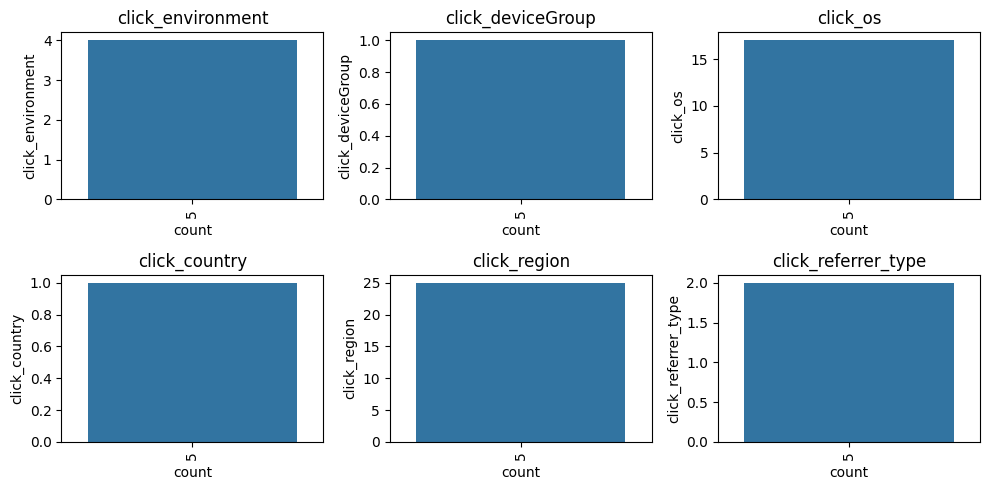

<Figure size 640x480 with 0 Axes>

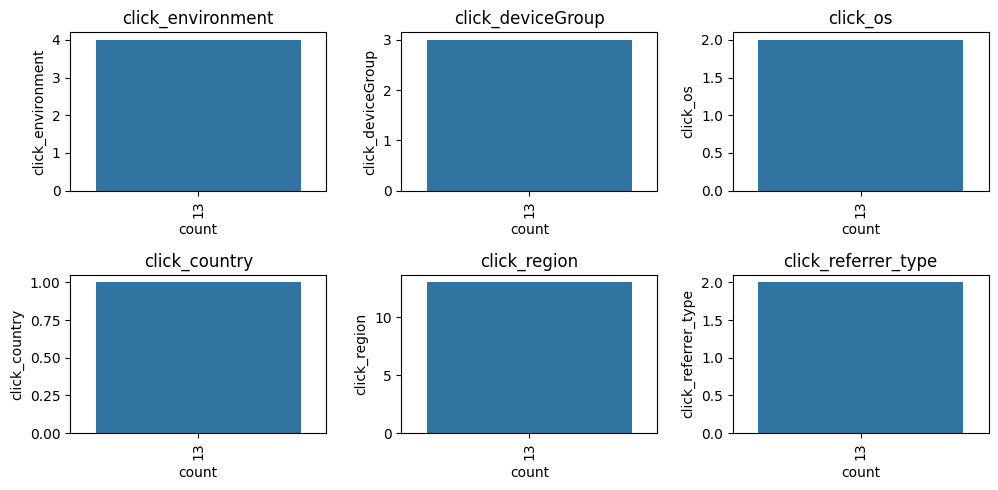

<Figure size 640x480 with 0 Axes>

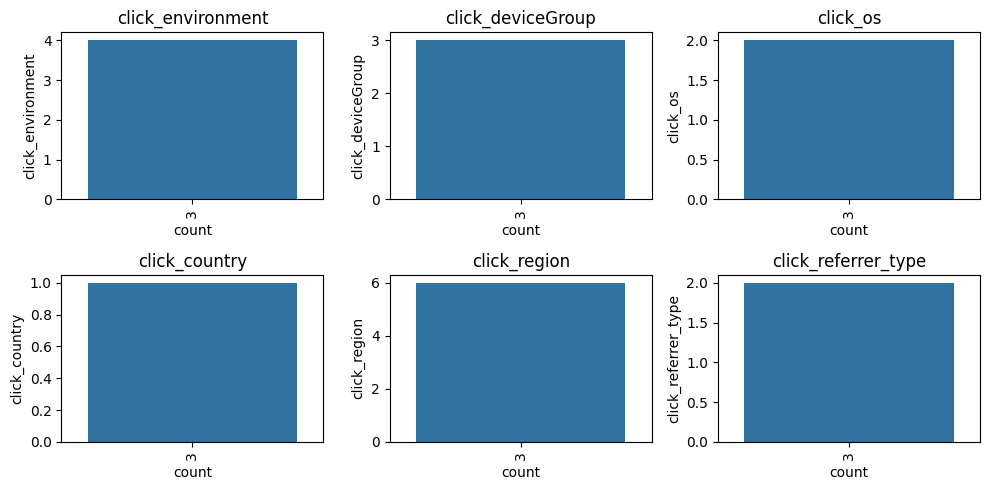

<Figure size 640x480 with 0 Axes>

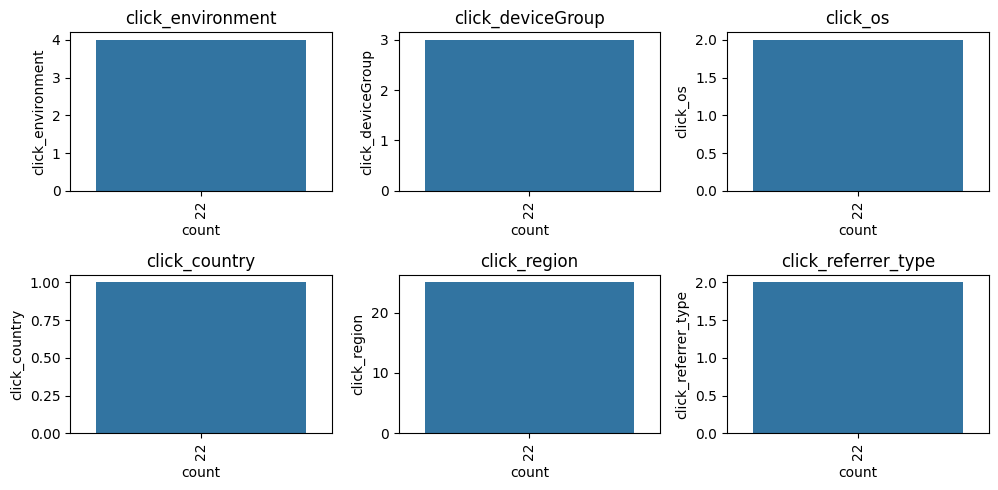

<Figure size 640x480 with 0 Axes>

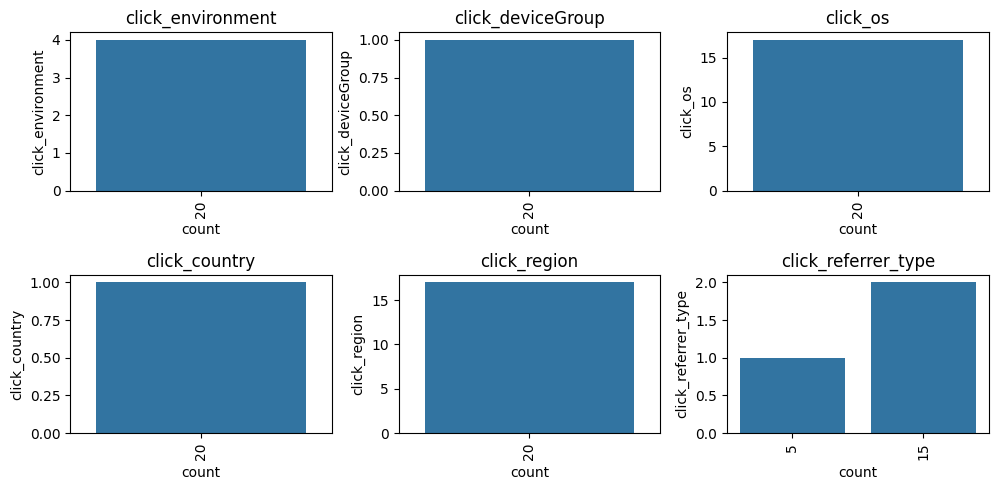

<Figure size 640x480 with 0 Axes>

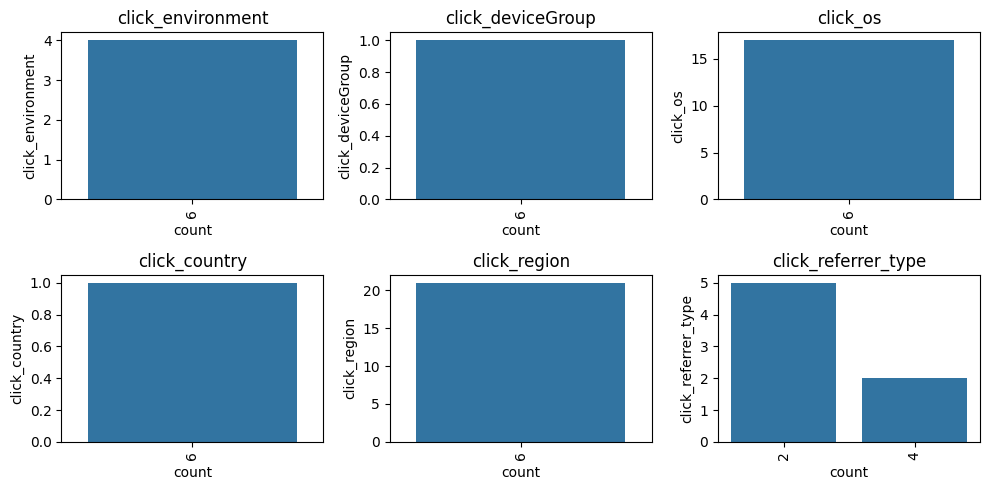

<Figure size 640x480 with 0 Axes>

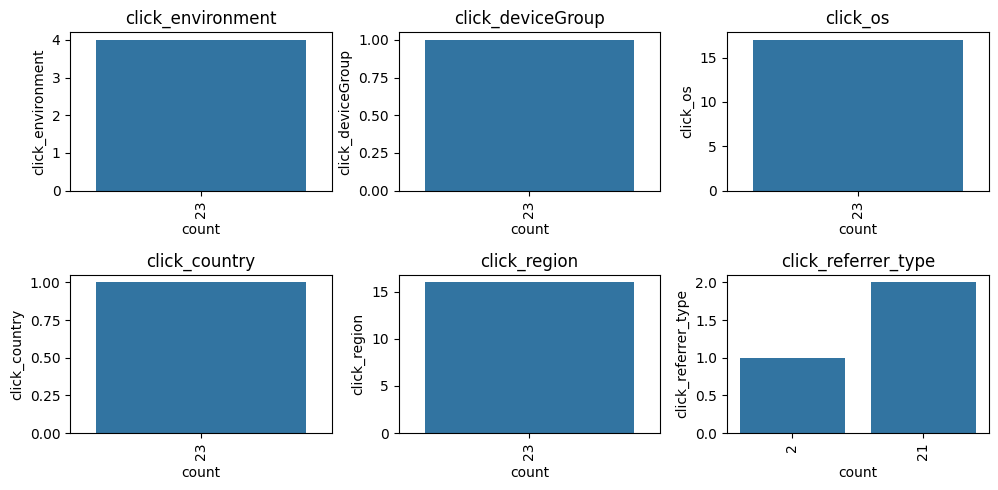

<Figure size 640x480 with 0 Axes>

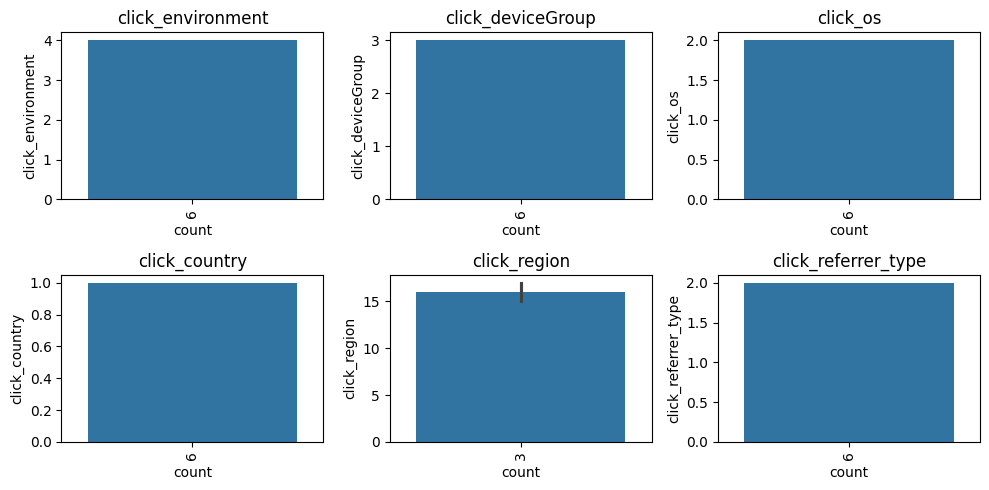

<Figure size 640x480 with 0 Axes>

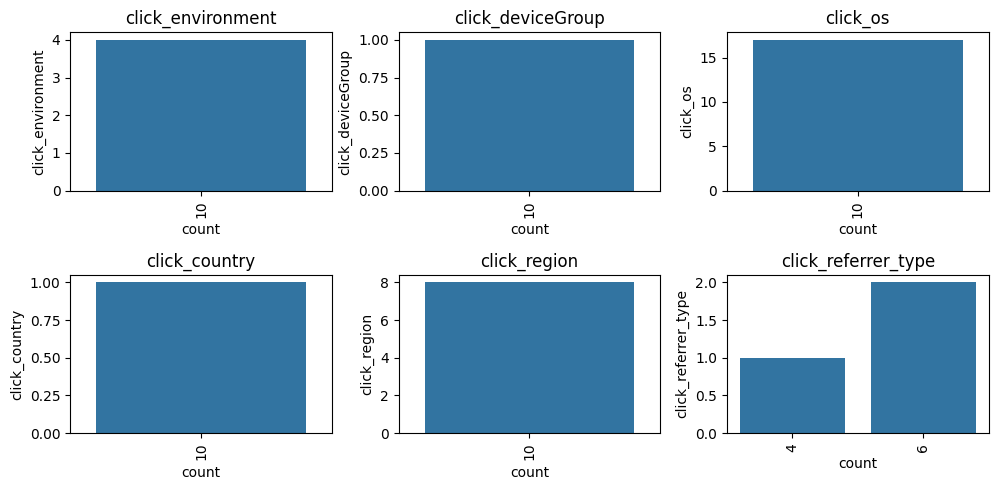

<Figure size 640x480 with 0 Axes>

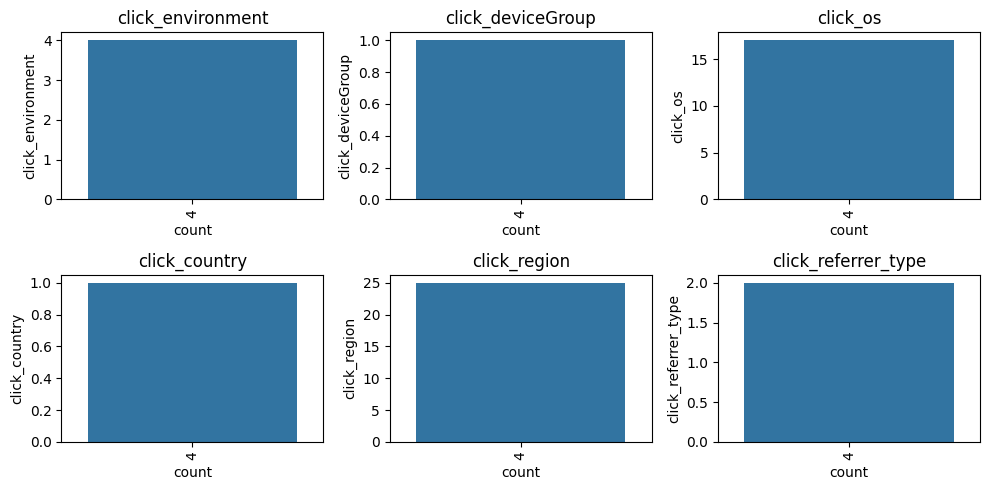

In [27]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

可以看出绝大多数数的用户的点击环境是比较固定的。可以基于这些环境的统计特征来代表该用户本身的属性。

## 用户点击新闻数量的分布
可以根据用户的点击文章次数看出用户的活跃度；更全面的，考虑点击时间。
分析可以发现，有非常明显的长尾效应

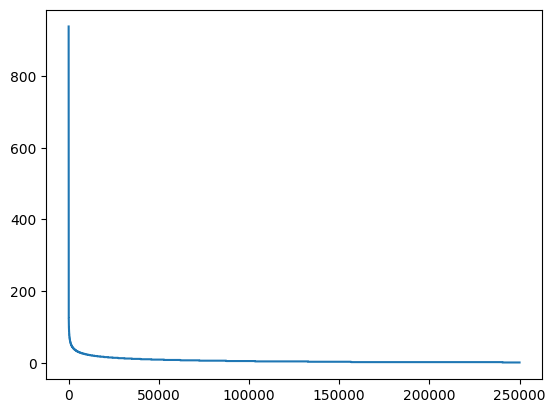

In [28]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

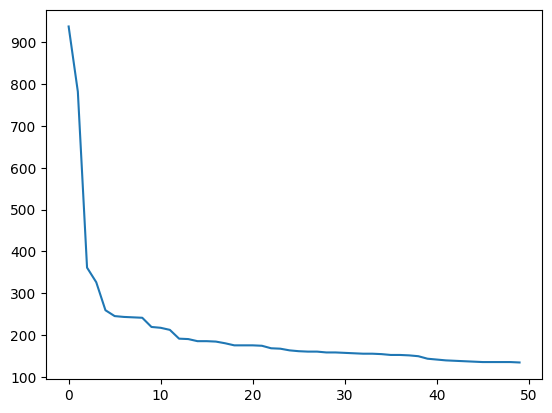

In [29]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

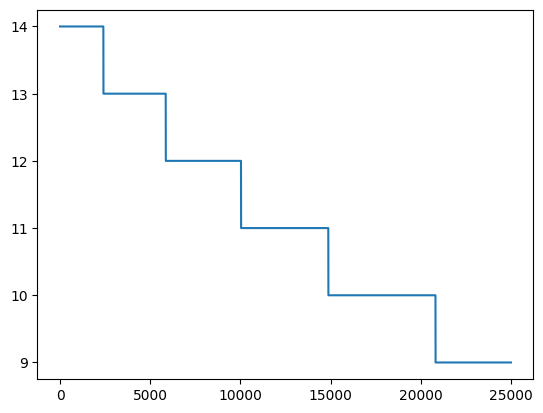

In [30]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

# 新闻被点击次数分析
划分热门文章和冷门文章

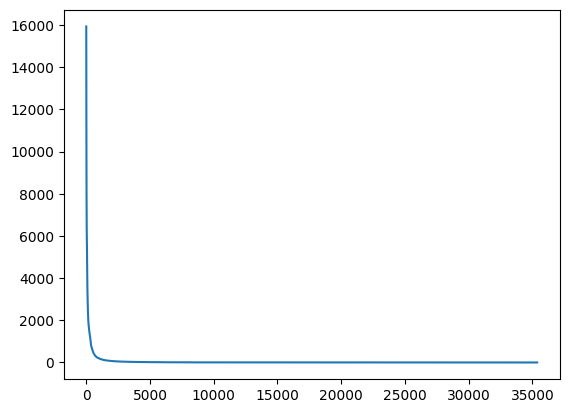

In [31]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)
plt.plot(item_click_count)

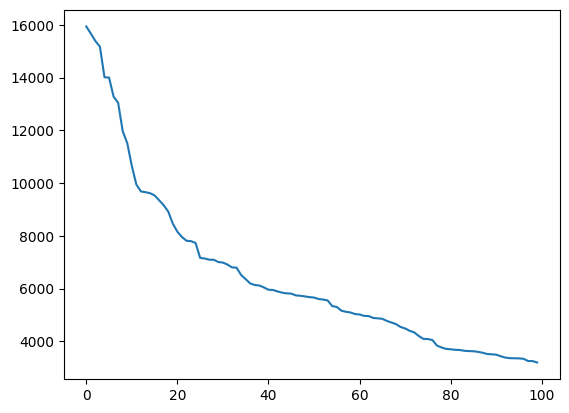

In [32]:
plt.plot(item_click_count[:100])


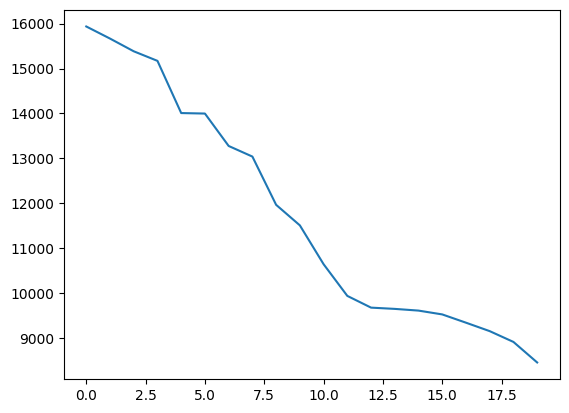

In [33]:
plt.plot(item_click_count[:20])

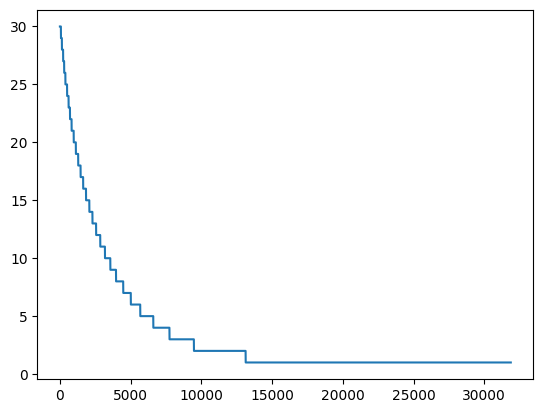

In [34]:
plt.plot(item_click_count[3500:])

## 新闻共现频次：两篇新闻连续出现的次数
按时间戳排序，两篇文章成对出现的次数

用户看了某一篇文章，紧接着去看了另一篇，这是完全相关的行为序列 -> 用户去看另一篇相似文章也是很大概率的

In [35]:
tmp = user_click_merge.sort_values('click_timestamp')
# 按用户分组后，next item 就是当前文章的下一条
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x: x.shift(-1))
# 聚合：统计共现次数；groupby 共现序列，聚合 条数，name is count, then sort
union_item = tmp.groupby(['click_article_id', 'next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)

union_item[['count']].describe()

,count
count,433596.000000
mean,3.184146
std,18.851689
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


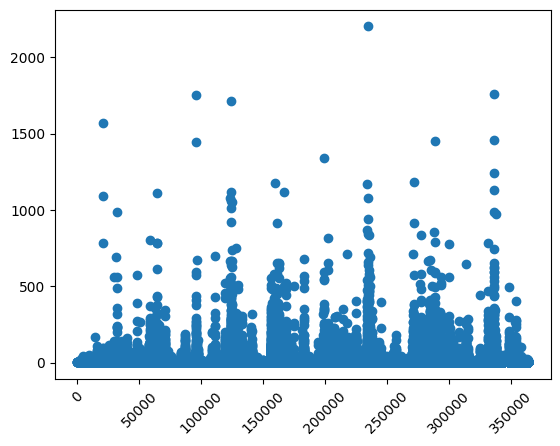

In [36]:
x = union_item['click_article_id']
y = union_item['count']
plt.tick_params(axis='x', rotation=45)
plt.scatter(x, y)

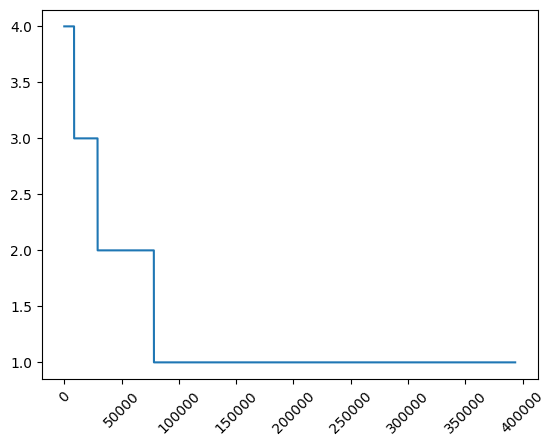

In [37]:
plt.tick_params(axis='x', rotation=45)
plt.plot(union_item['count'].values[40000:])

大概有75000个pair至少共现一次

## 新闻文章信息

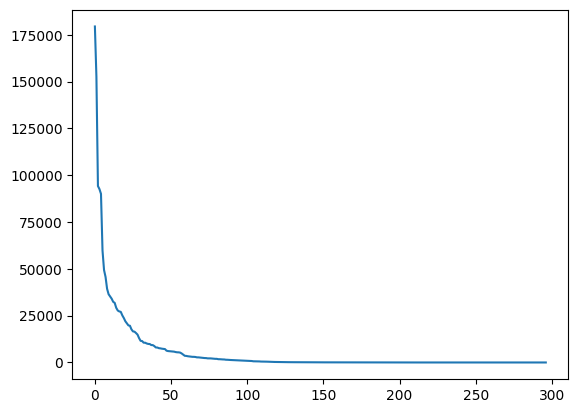

In [42]:
plt.plot(user_click_merge['category_id'].value_counts().values)

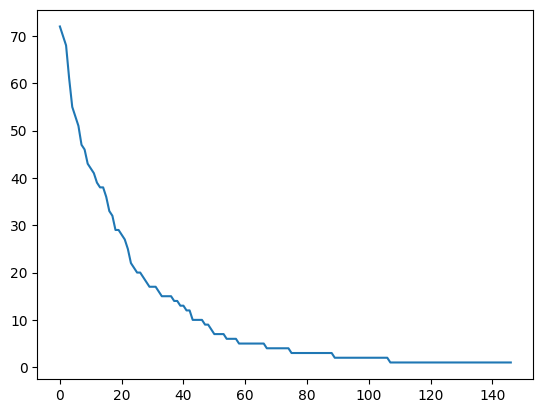

In [43]:
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [44]:
# 新闻字数
user_click_merge['words_count'].describe()

,words_count
count,1.630633e+06
mean,2.043012e+02
std,6.382198e+01
min,0.000000e+00
25%,1.720000e+02
50%,1.970000e+02
75%,2.290000e+02
max,6.690000e+03


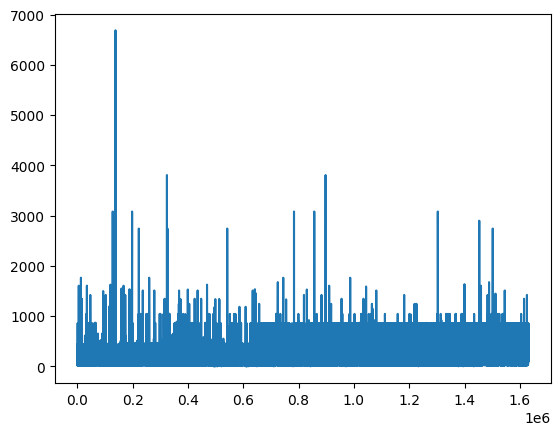

In [45]:
plt.plot(user_click_merge['words_count'].values)

## 用户点击的新闻类型的偏好
统计用户点击过的新闻类别的数量

从x下图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在20个新闻类型以下

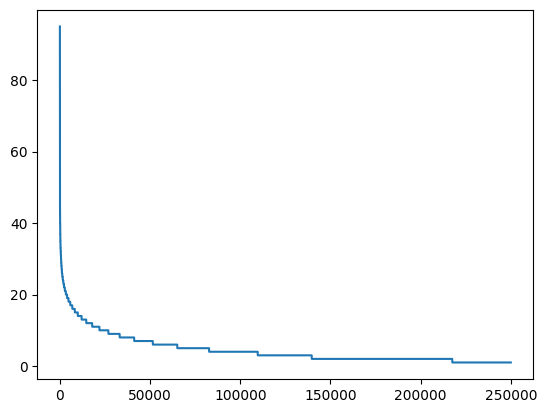

In [46]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

In [47]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


## 用户查看文章的长度的分布
通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣

可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。大多数人偏好于阅读字数在200-400字之间的新闻。

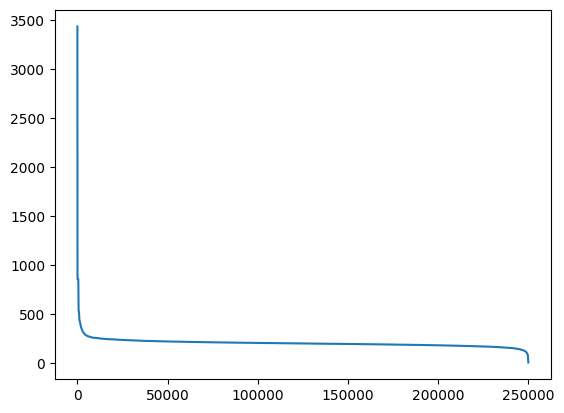

In [48]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

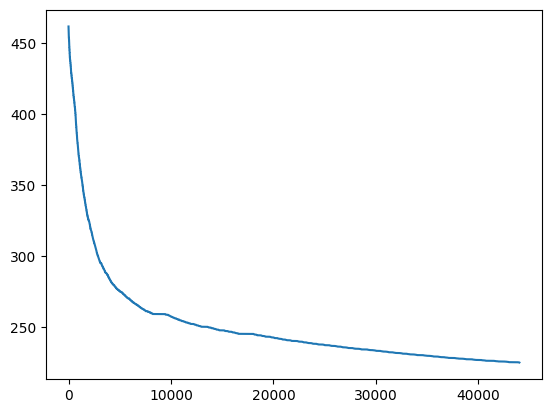

In [49]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

In [50]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


## 用户点击新闻的时间分析


In [51]:
# 为了更好的可视化，对时间做归一化
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge_ = user_click_merge.sort_values('click_timestamp')

user_click_merge_.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
517916,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
517990,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
517870,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
517797,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
517891,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


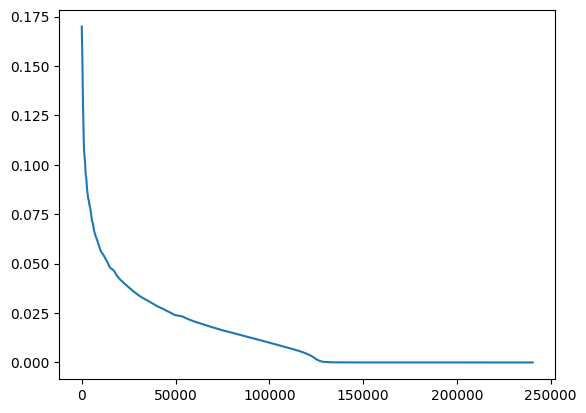

In [52]:
# 用户两次点击时间差的平均值
user_click_merge_ = user_click_merge_.sort_values(['user_id', 'click_timestamp'])

# 向量化计算（快！）
mean_diff_click_time = (
    user_click_merge_
    .groupby('user_id')['click_timestamp']
    .diff()          # 组内差分（自动处理分组边界）
    .abs()           # 绝对值
    .groupby(user_click_merge_['user_id'])  # 再次按user_id分组
    .mean()          # 计算平均值（自动忽略NaN）
).sort_values(ascending=False)

# 绘图
plt.plot(sorted(mean_diff_click_time.values, reverse=True))

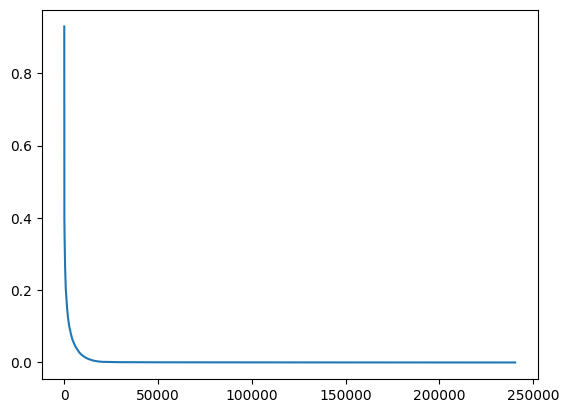

In [53]:
mean_diff_created_time = (
    user_click_merge_
    .groupby('user_id')['created_at_ts']
    .diff()          # 组内差分（自动处理分组边界）
    .abs()           # 绝对值
    .groupby(user_click_merge_['user_id'])  # 再次按user_id分组
    .mean()          # 计算平均值（自动忽略NaN）
).sort_values(ascending=False)

# 绘图
plt.plot(sorted(mean_diff_created_time.values, reverse=True))

In [54]:
# 安装gensim
!pip install gensim

In [71]:
from gensim.models import Word2Vec
import logging, pickle

# one epoch training, use w2v to measure the similarity of content between news
def trian_item_word2vec(click_df, epochs=10, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, vector_size=embed_size, sg=1, window=5, seed=2020, workers=24, min_count=1, epochs=epochs)

    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v.wv[k] for k in click_df['click_article_id'].unique()}

    return item_w2v_emb_dict

In [72]:
# 训练多次，得到两两文章的相似性
item_w2v_emb_dict = trian_item_word2vec(user_click_merge, epochs=20)

In [63]:
# 随机选择5个用户
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
9440,3829,50405,0.333180,4,3,2,1,13,1,1,2,99,0.991663,217
9441,3829,50494,0.333172,4,3,2,1,13,1,2,2,99,0.992696,192
18393,7236,58898,0.327365,4,1,17,1,8,1,1,4,118,0.992024,118
18394,7236,57605,0.327357,4,1,17,1,8,1,2,4,118,0.992210,197
18395,7236,57485,0.327349,4,1,17,1,8,1,3,4,118,0.992276,139


In [64]:
def get_item_sim_list(df):
    '''
    计算用户点击序列中相邻文章的相似度列表

    参数:
        df: DataFrame，包含该用户的点击记录（已按时间排序）

    返回:
        sim_list: 相似度列表，长度 = len(df)
    '''
    sim_list = []
    item_list = df['click_article_id'].values # 获取文章ID列表

    #  遍历相邻的文章对
    for i in range(0, len(item_list)-1):
        # 两篇文章的 embedding
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        # 计算余弦相似度: cos(θ) = A·B / (||A|| * ||B||)
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    # 添加占位
    sim_list.append(0)
    return sim_list

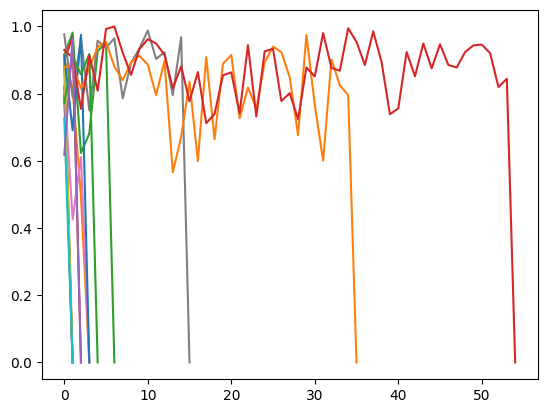

In [65]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)